In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
import math
from scipy.signal import kaiserord, lfilter, firwin, freqz, medfilt
import numpy as np
import scipy.signal as signal


In [47]:
# Import der CSV Daten
dfx = pd.read_csv("./run/ID_001_Run  02_Complete_Run.csv", sep=",", decimal=".", encoding='ansi')
dfx = dfx.rename(columns=str.lower)
dfx.columns = dfx.columns.str.replace(' ','_')

for index, row in dfx.iterrows():
    if row["_lightbeam"].strip() == "B12":
        break
    else:
        dfx.drop(index=index,inplace=True)
        #print(index)

counter =0
for index, row in dfx.iterrows():
    if row["_lightbeam"].strip() == "2":
        counter=1
        continue
    if counter ==1:
        dfx.drop(index=index,inplace=True)
    


#df = dfx[(dfx["time_s"] >= 0) & (dfx["time_s"]<=18)]
df = dfx
# Tilt Angle berechnen -(math.degrees(math.atan(12/100)))
df["tilt_value"] = -(np.degrees(np.arctan(df["_acc_y_m/s2"]/df["_acc_x_m/s2"])))

#df["opt_roll"] = np.arctan()

# First, design the Buterworth filter
N  = 3    # Filter order
Wn = 0.01 # Cutoff frequency Hz (1/500)
B, A = signal.butter(N, Wn, output='ba', btype='lowpass')
df['acc_x_smooth'] = signal.filtfilt(B,A, df["_acc_x_m/s2"])
df['acc_y_smooth'] = signal.filtfilt(B,A, df["_acc_y_m/s2"])
df['acc_z_smooth'] = signal.filtfilt(B,A, df["_acc_z_m/s2"])
# Tilt Angle berechnen -(math.degrees(math.atan(12/100)))
df['tilt_smooth'] = -(np.degrees(np.arctan((df['acc_y_smooth'])/(df['acc_x_smooth']))))
df['tilt_valsm'] = -(np.arctan((df['acc_y_smooth'])/(df['acc_x_smooth'])))

## Jetzt noch den optimalen Rollwinkel
## https://www.rathaus-winterberg.de/wohnen-leben/bau-planen/bebauungsplaene/
## https://geoservice.maps.arcgis.com/apps/View/index.html?appid=9565f4b2c14544b4a92b04a67958c79c


# df.loc[df["_roll_angle_°"] <=10, 'radius'] =0  
df.loc[(df["_roll_angle_°"] <= (-30) ) & (df["time_s"] >=1 ), 'radius'] = 38.5 
df.loc[(df["_roll_angle_°"] > 50 ) & (df["time_s"] >=8 ), 'radius'] = 20.5 

# Definieren von Speed und Radius
velocity = df["_speed_km/h"]/3.6
radius = df['radius']

df.loc[df["radius"] == 0, 'opt_rangle'] = 0

df.loc[df["radius"] == 20.5, 'opt_rangle'] = np.degrees(np.arctan((velocity ** 2)/(9.81*radius)))
df.loc[df["radius"] == 38.5, 'opt_rangle'] = -(np.degrees(np.arctan((velocity ** 2)/(9.81*radius))))


#df["opt_rangle"] = (np.degrees(np.arctan((velocity ** 2)/(9.81*radius))))



# Daten in CSV sichern...
#pd.DataFrame(df).to_csv("c:/dev/test_v3.csv",sep=";")
df= df.reset_index(drop=True)
curve_count = (df.time_s).count()
curve_size = 180 # Grad der Kurve

for index, row in df.iterrows():
    df.at[index, 'curve_angle'] =  (index*(180/curve_count))
df.head()


,time_s,_distance_m,_speed_km/h,_acc_x_m/s2,_acc_y_m/s2,_acc_z_m/s2,_roll_angle_°,_lightbeam,_lb_time_s_°_,tilt_value,acc_x_smooth,acc_y_smooth,acc_z_smooth,tilt_smooth,tilt_valsm,radius,opt_rangle,curve_angle
0,12.50,186.202,74.000,-0.061,0.092,12.577,-0.181,B12,12.950,56.453891,-0.024550,-0.367711,13.318037,-86.180386,-1.504131,NaN,NaN,0.000000
1,12.51,186.404,73.994,-0.065,0.082,12.540,-0.091,,,51.596738,-0.025673,-0.378393,13.345197,-86.118566,-1.503053,NaN,NaN,0.327273
2,12.52,186.604,73.985,-0.070,0.069,12.502,0.000,,,44.587807,-0.026834,-0.388832,13.372814,-86.052150,-1.501893,NaN,NaN,0.654545
3,12.53,186.803,73.975,-0.075,0.053,12.464,0.079,,,35.247575,-0.028034,-0.399015,13.400885,-85.981163,-1.500654,NaN,NaN,0.981818
4,12.54,187.002,73.964,-0.081,0.036,12.429,0.159,,,23.962489,-0.029272,-0.408931,13.429407,-85.905601,-1.499336,NaN,NaN,1.309091


In [13]:
# Modifizieren der Daten
plot_data = df.iloc[:,[0,1,2,6,9]]
#plot_data.describe()


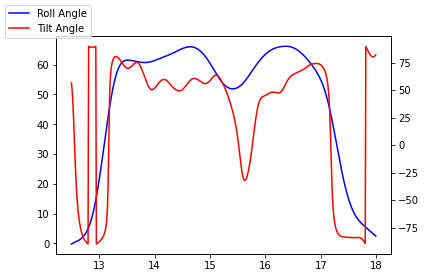

<Figure size 1116x396 with 0 Axes>

In [14]:
# Roll Angle muss jetzt ins psitive gewandelt werden

#plt.plot(plot_data.iloc[:,0],plot_data.iloc[:,3].abs(),'blue',plot_data.iloc[:,0],plot_data.iloc[:,2],"red")
fig, ax1 = plt.subplots()
plt.figure(figsize=(15.5, 5.5))
ax2 = ax1.twinx()
#ax1.plot(plot_data.iloc[:,0],plot_data.iloc[:,3].abs(),'blue')
ax1.plot(plot_data.iloc[:,0],plot_data["_roll_angle_°"],'blue', label='Roll Angle')
#ax2.plot(plot_data.iloc[:,0],plot_data.iloc[:,2],"red")
ax2.plot(plot_data.iloc[:,0],plot_data["tilt_value"],"red", label='Tilt Angle')
fig.legend(loc='upper left')
plt.show()



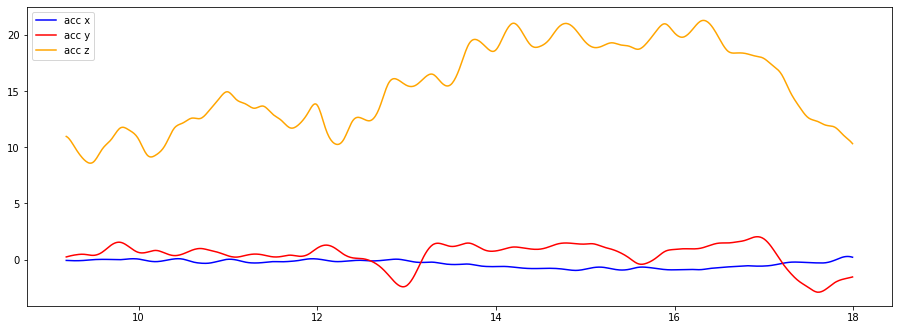

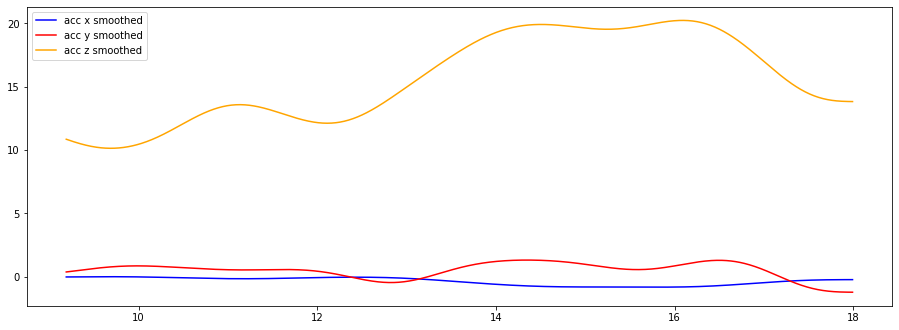

In [51]:

plt.figure(figsize=(15.5, 5.5))
plt.plot(df['time_s'],df["_acc_x_m/s2"],'blue', label='acc x')
plt.plot(df['time_s'],df["_acc_y_m/s2"],'red', label='acc y')
plt.plot(df['time_s'],df["_acc_z_m/s2"],'orange', label='acc z')
plt.legend(loc='upper left')
plt.show()
plt.figure(figsize=(15.5, 5.5))
plt.plot(df['time_s'],df["acc_x_smooth"],'blue', label='acc x smoothed')
plt.plot(df['time_s'],df["acc_y_smooth"],'red', label='acc y smoothed')
plt.plot(df['time_s'],df["acc_z_smooth"],'orange', label='acc z smoothed')
plt.legend(loc='upper left')
plt.show()


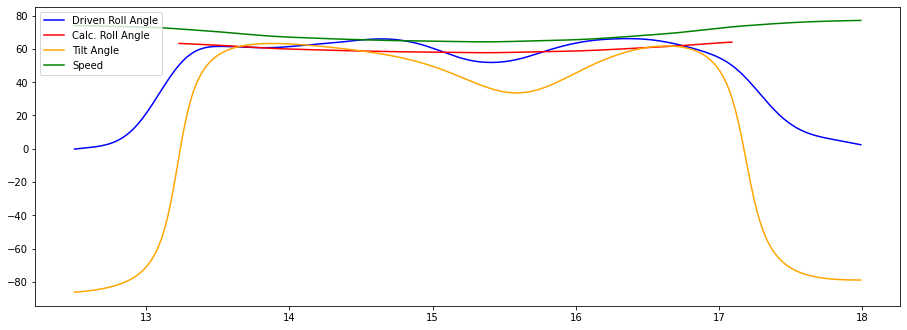

In [15]:
#tiltsmooth = scipy.signal.savgol_filter(df["tilt_value"], 99, 2, mode='nearest')
plt.figure(figsize=(15.5, 5.5))
plt.plot(df['time_s'],df['_roll_angle_°'],'blue', label='Driven Roll Angle') 
plt.plot(df['time_s'],df['opt_rangle'],'red', label='Calc. Roll Angle')
plt.plot(df['time_s'],df['tilt_smooth'],'orange', label='Tilt Angle')
plt.plot(df['time_s'],df['_speed_km/h'],'green', label='Speed')
#plt.plot(df['time_s'],df['tilt_smooth'],'blue',df['time_s'],df['_roll_angle_°'],'red',df['time_s'],df['acc_z_smooth'],'orange' )
plt.legend(loc='upper left')
plt.show()

https://raw.githubusercontent.com/DFRobot/DFRobotMediaWikiImage/master/Image/_Tilt_angle.png



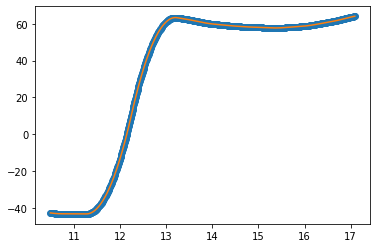

In [95]:
from scipy.interpolate import interp1d
x = df['time_s']
y = df['opt_rangle'].interpolate(method='polynomial', order=2)
f =  interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--')
plt.show()

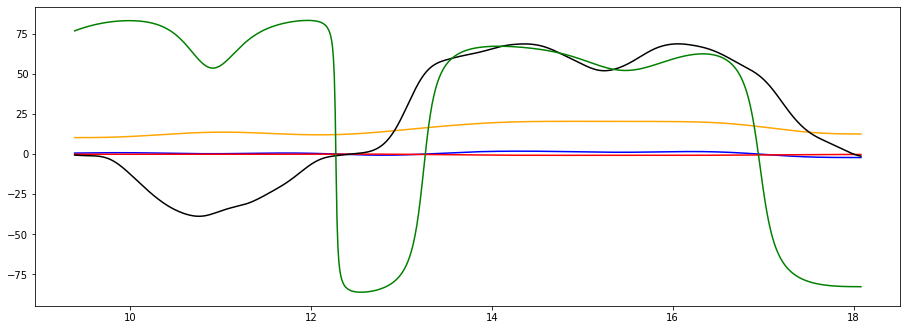

In [151]:
# https://itectec.com/electrical/electrical-how-to-choose-a-cut-off-frequency-by-interpreting-fft/
# https://www.engineeringtoolbox.com/banked-turn-d_1844.html
# https://www.bigrentz.com/blog/superelevation

plt.figure(figsize=(15.5, 5.5))
#plt.plot(rawdatax,'r-')
plt.plot(df['time_s'],df['acc_y_smooth'],'b-')
plt.plot(df['time_s'],df['acc_x_smooth'],'r-')
plt.plot(df['time_s'],df['acc_z_smooth'],'orange')
plt.plot(df['time_s'], df["_roll_angle_°"], "black")
plt.plot(df['time_s'], df['tilt_smooth'], "green")
plt.show()

<Figure size 2160x7344 with 0 Axes>

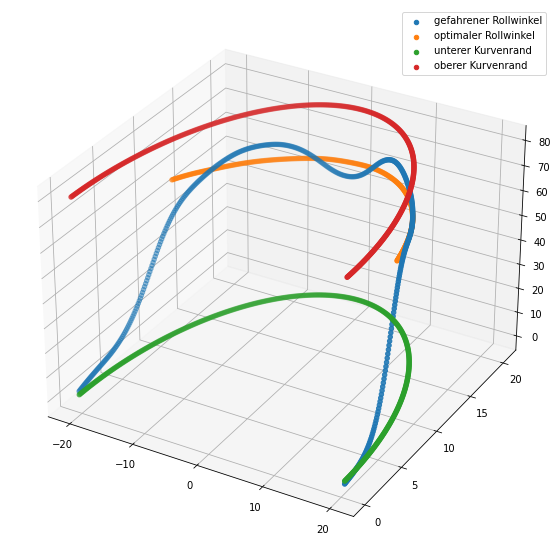

In [92]:
fig = plt.figure()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

z = df['_roll_angle_°']
x = 20.5 * np.cos(np.radians(df['curve_angle']))
y = 20.5 * np.sin(np.radians(df['curve_angle']))

z_line = df['opt_rangle']
z_bot = 1
z_top= 80

ax.scatter3D(x, y, z, lw=1,label='gefahrener Rollwinkel')
ax.scatter3D(x, y, z_line, lw=1, label='optimaler Rollwinkel')
ax.scatter3D(x, y, z_bot, lw=1,label='unterer Kurvenrand')
ax.scatter3D(x, y, z_top, lw=1, label='oberer Kurvenrand')
ax.legend()

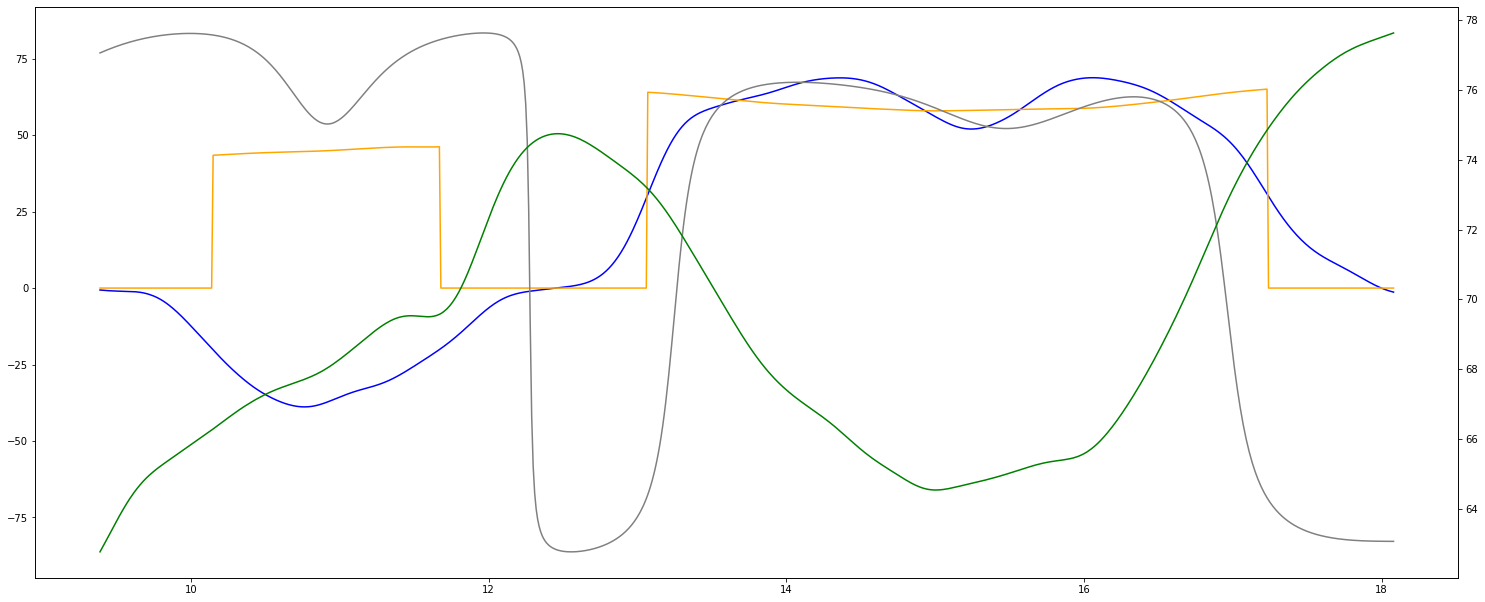

In [153]:
fig, ax1 = plt.subplots()
fig.set_size_inches(25.5, 10.5)
ax2 = ax1.twinx()

ax1.plot(df['time_s'],df["_roll_angle_°"],'blue',df['time_s'],df["opt_rangle"],'orange',df['time_s'],df["tilt_smooth"],'grey' )
#ax1.plot(df['time_s'],df["_roll_angle_°"],'blue',df['time_s'],df["acc_z_smooth"],'orange' )
ax2.plot(df['time_s'],df["_speed_km/h"],"green")
plt.show()

TypeError: float() argument must be a string or a number, not 'interp1d'

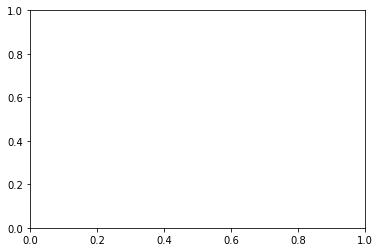

In [6]:
from scipy.interpolate import interp1d

df['interpolate'] = interp1d(df['time_s'],df['opt_rangle'], kind='cubic')
#xnew = np.linspace(0, 10, num=41, endpoint=True)

plt.plot(df['time_s'], df['interpolate'], '--')
#plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [219]:
#Los geht es mit einer Linearen Regression
# time_s	_distance_m	_speed_km/h	_acc_x_m/s2	_acc_y_m/s2	_acc_z_m/s2	_roll_angle_°	tilt_value	acc_x_smooth	acc_y_smooth	acc_z_smooth	tilt_smooth
from sklearn.linear_model import LinearRegression
predictors = ['_distance_m','_roll_angle_°', 'tilt_value' ]
outcome = ['_speed_km/h']

bob_lm = LinearRegression().fit(df[predictors], df[outcome])


# The following section will get results by interpreting the created instance: 

# Obtain the coefficient of determination by calling the model with the score() function, then print the coefficient:
r_sq = bob_lm.score(df[predictors], df[outcome])
print('coefficient of determination:', r_sq)

# Print the Intercept:
print('intercept:', bob_lm.intercept_)

# Print the Slope:
print('slope:', bob_lm.coef_) 

# Predict a Response and print it:
y_pred = bob_lm.predict(df[predictors])
print('Predicted response:', y_pred, sep='\n')

coefficient of determination: 0.8468775986358665
intercept: [34.92925692]
slope: [[ 0.15526907 -0.06774889  0.00641625]]
Predicted response:
[[37.09549689]
 [37.1089572 ]
 [37.12115011]
 ...
 [89.71465344]
 [89.68832137]
 [89.65152541]]


<function matplotlib.pyplot.show(close=None, block=None)>

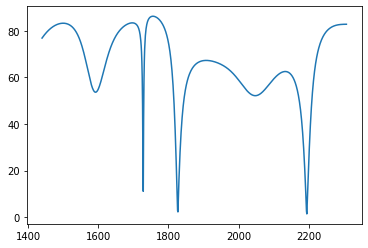

In [154]:
# Peaks müssen noch entfernt werden um z.B. die Fahrten an die Band zu eliminieren
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html --> Hat nicht zum Ziel geführt
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html --> Auch keine gute Lösung

def despike(yi, th=1.e-8):
#'''Remove spike from array yi, the spike area is where the difference between 
#  the neigboring points is higher than th.'''
  y = np.copy(yi) # use y = y1 if it is OK to modify input array
  n = len(y)
  x = np.arange(n)
  c = np.argmax(y)
  d = abs(np.diff(y))
  try:
    l = c - 1 - np.where(d[c-1::-1]<th)[0][0]
    r = c + np.where(d[c:]<th)[0][0] + 1
  except: # no spike, return unaltered array
    return y
  # for fit, use area twice wider then the spike
  if (r-l) <= 3:
    l -= 1
    r += 1
  s = int(round((r-l)/2.))
  lx = l - s
  rx = r + s
  # make a gap at spike area
  xgapped = np.concatenate((x[lx:l],x[r:rx]))
  ygapped = np.concatenate((y[lx:l],y[r:rx]))
  # quadratic fit of the gapped array
  z = np.polyfit(xgapped,ygapped,2)
  p = np.poly1d(z)
  y[l:r] = p(x[l:r])
  return y

#testx <- df['tilt_smooth']
test = despike(df['tilt_smooth'])

plt.plot(df['tilt_smooth'].abs())
plt.show

KeyError: "None of [Int64Index([258, 694], dtype='int64')] are in the [index]"

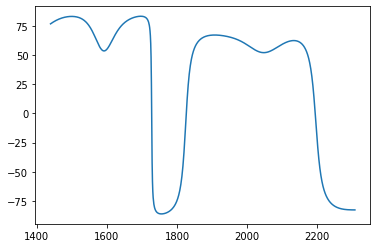

In [155]:
import matplotlib.pyplot as plt

from scipy.misc import electrocardiogram

from scipy.signal import find_peaks

x = df['tilt_smooth']

#peaks, _ = find_peaks(x, height=89)

peaks, _ = find_peaks(x, distance=400)

np.diff(peaks)

plt.plot(x)

plt.plot(peaks, x[peaks], "x")

plt.plot(np.zeros_like(x), "--", color="gray")

plt.show()



In [89]:
print(df[outcome])

      _speed_km/h
0          -0.000
1          -0.000
2          -0.000
3          -0.000
4          -0.000
...           ...
6562       72.913
6563       72.878
6564       72.841
6565       72.801
6566       72.759

[6567 rows x 1 columns]
